# Micrograd 🔧

> Spelled-out intro to neural networks and backpropagation
 
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter, kaggle]

### A blog implementation of Andrej Karpathy's [micrograd video](https://youtu.be/VMj-3S1tku0) 
### Work in progress will continually add to this blog

<a id=content></a>
**Content:**
### 1. [Derivative of a function](#1)
### 2. [Core Value Object](#2)
### 3. [Manual Backpropagation](#3)
### 4. [Backward function](#4)
### 5. [More operations](#5)
### 6. [Pytorch](#6)

<a id=1></a>
# [Lets get an intuitive understanding of what a derivative is](#content)

In [143]:
#basic imports
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Lets use a simple quadratic function as an example <br />
<br/>
## $f(x) = 3x^2 - 4x + 5$


In [144]:
def f(x):
    return 3*x**2 - 4*x + 5

In [145]:
f(3.0)

20.0

Take a look at the shape of the function, we can expect a parabola since we know its a quadratic function 

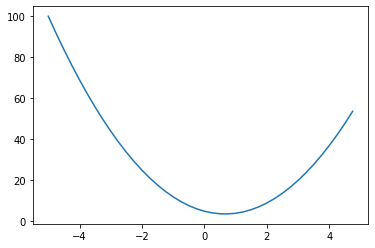

In [146]:
# creating a range of x values from -5 to 5 incrementing by 0.25 to pass into our function to generate our y values
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

We know want to think through what is the derivative of this function at different points x, let refresh with the definition of a derivative 
## $f'(x) = lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$ 


You are basically trying to see the level of sensitivty the function responds with by bumping any x value at any point slightly by this small number h </br>
Intuitively how would you expect this function to respond if we nudged x = 3.0 by this small postitive number h? The amount the x value responds tells you the strength of the slope

In [147]:
h = 0.0001
x = 3.0
print(f'slope of function at x = {x}, slope = {(f(x + h) - f(x)) / h}')

slope of function at x = 3.0, slope = 14.000300000063248


Lets do a hacky implementation with more variables </br>
Look at the function a*b + c in relation to the variables we assigned, imagine if you nudged each variables by a tiny amount would that result in our output being increased or decreased? </br>
If we were to slightly nudge each of our input varibles by the tiny amount h(amount approaching 0) we can approximate the instataneous rate of change by looking at the difference before and after over the amount we nudged by, this will give us the slope.


In [148]:
# lets get more complex
h = 0.0001
#inputs
a = 2.0
b = -3.0
c = 10.0

#We wanna find the derivative of d with respect to a,b,c
d1 = a*b + c
a +=  h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


Lets do it with b now


In [149]:
d1 = a*b + c
b +=  h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947


And c...

In [150]:
d1 = a*b + c
c +=  h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 3.99990001
d2 4.00000001
slope 0.9999999999976694


Hopefully this has helped build an inuitive sense of what this derivative is telling you about the function, but now we want to move to neural networks, which will be massive mathmatical expressions, so we need some structures to maintain these expressions, so we will build out a value object that can keep track of state and allow us to do expressions  

<a id=2></a>
# [Core Value Object](#content)

In [151]:
class Value:
    
    def __init__(self, data):
        self.data = data
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
    
a = Value(2.0)
b = Value(-3.0)
a + b

a * b

Value(data=-6.0)

We use double underscore or dunder methods so python knows what to interally when we use operators such as print, +, -, * </br>
So when we call ```a + b``` above what is happening interally is ```a.__add__(b)``` with self as a and b as other. Similarly when we do ```a * b```, python is calling ```a.__mul__(b)``` 

Cool so now we can do basic arthmetic now we need to add pointers to what see values produce other values and by what operations

In [152]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out 
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
        
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

Now that we have the a way to store the parents, labels and operations we can visualize them with an expression graph, code below allows us to do that using a library called graphviz

In [153]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

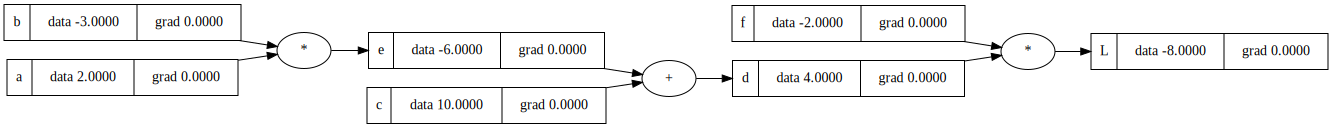

In [154]:
draw_dot(L)

Lets recap:
- we are able to build out mathematical expressions using + and *
- Added and tracked grad so we can calculate and update this state later when we do backpropagtion
- Forward pass that produces output L and visualized
- Now we want to do backpropagation

<a id=3></a>
# [Manual Backpropagation](#content)

Lets manually nudge the variable a and manually calculate the derivative of L with respect to a, lets create a gating function lol so we don't pollute the global scope. We can do this for each variable to calculate their derivative with respect to L

![image.png](https://i.imgur.com/c53qrkN.png)

### $L = d * f$
### $\frac{dL}{dd} =? f$
### $lim_{h \to 0} \frac{(d+h)*f - d*f}{h}$ 
### $lim_{h \to 0} \frac{d*f + h*f - d*f}{h}$ 
### $lim_{h \to 0} \frac{h*f}{h}$ 
### $f$ 
So we can see that d.grad is just the value of f which is -2.0 and by the property of symmetry f.grad is just the value of d which is 4.0, lets go ahead and manually set these

In [155]:
f.grad = 4.0
d.grad = -2.0

In [156]:
L.grad = 1

In [157]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    # this is the variable we are nudging by h
    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
lol()

-1.9999999999953388


So we have just derived the derivates of f and d with respect to L in a step by step way, now next will uncover the core of backpropagation, we want derive the derivative of L with respect to c and e. </br>
We now know how L is sensitive to d and we know how e and c are sensitive to d, we can know put that together to figure out how L is sensitive to e and c.

### If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as
# $\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx}$
The chain rule is fundamentally telling you how we chain these derivatives together correctly so to differentiate through a function composition we have to apply a multiplication of those derivatives </br>
```The inuitive explanation here is that knowing the instantaneous rate of change of z with respect to y and y relative to x allows one to calculate the instantaneous rate of change of z```

### If a car travels twice as fast as a bicyle and the cycle is four times as fast as a walking man then the car is 2 * 4 = 8 times faster than the man </br>
We know the derivative of $\frac{dL}{dd}$ and $\frac{dd}{dc}$ and want to find $\frac{dL}{dc}$ the chain rule tells us that $\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc}$  
$1.0 * -2.0 = -2.0$

The chain rule is telling us for plus nodes "+" we are just routing the gradient because the local derivative is just 1.0

In [158]:
e.grad = -2.0
c.grad = -2.0

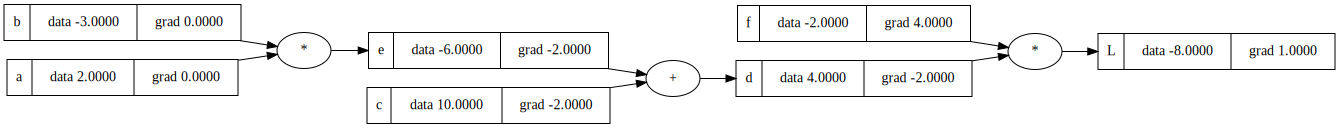

In [159]:
draw_dot(L)

### Lets manually check our work by nudging c

In [160]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    # this is the variable we are nudging by h
    c = Value(10.0, label='c')
    c.data += h
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
lol()

-1.9999999999953388


As we expected c.grad equals -2.0*

## Now we will recurse our way backwards again and going to do our second application of the chain rule
### $\frac{dL}{de} = -2.0$ </br>
### $\frac{de}{da} = b$ </br>
### $\frac{dL}{da} = \frac{dL}{de} * \frac{de}{da}$

We are multiplying the derivative of e with respect to L with the local gradients

In [161]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

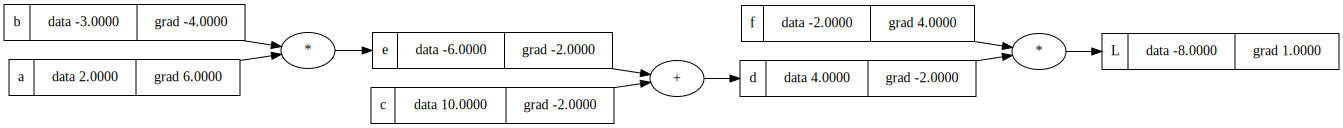

In [162]:
draw_dot(L)

Lets verify

In [163]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    # this is the variable we are nudging by h
    a = Value(2.0 , label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
lol()

6.000000000021544


Checks out

## We know know what back propagation is;  a recursive application of the chain rule backwards through the computational graph

## Neuron Example

One step optimization

In [164]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


![image.png](https://blog.liang2.tw/2015Talk-DeepLearn-CNN/pics/external/cs231n_note_neuron.png)

For our model of neurons we have input axis and these synapses that have weights on them so the w's are the weights and then the synapse interacts with the input multiplicatively so what flows to the cell body of this neuron is w times x but there's multiple inputs so there's many w times x's flowing into the cell body, the cell body also has some bias which is a sort of trigger happiness of this neuron, making it more or less prone to firing. Then we take it through an activation function which is generally some kinda of squashing function like a sigmoid or tanh. Lets go over an example of a tanh activation function 

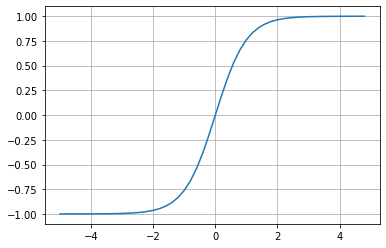

In [165]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

You can see that the inputs that come in get squashed here on the y axis, the function gets capped at 1.00 and -1.00

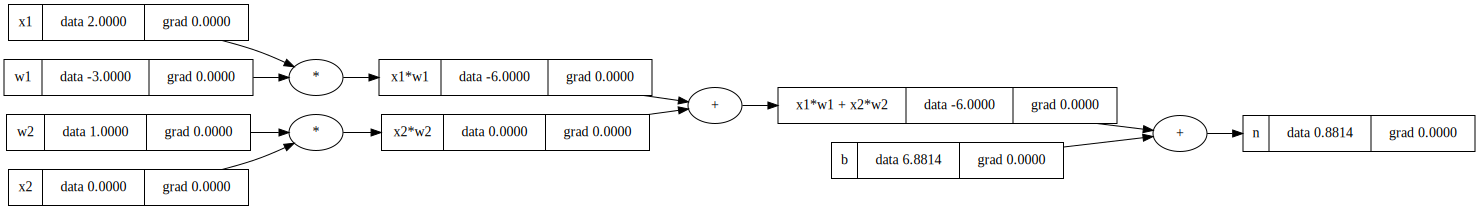

In [166]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
#6.8813735870195432
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
draw_dot(n)

We need to add more operations to our Value class to be able to calculate our activation function tanh, lets just do a cheeky implementation of tanh on our value class for now

In [167]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out 
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

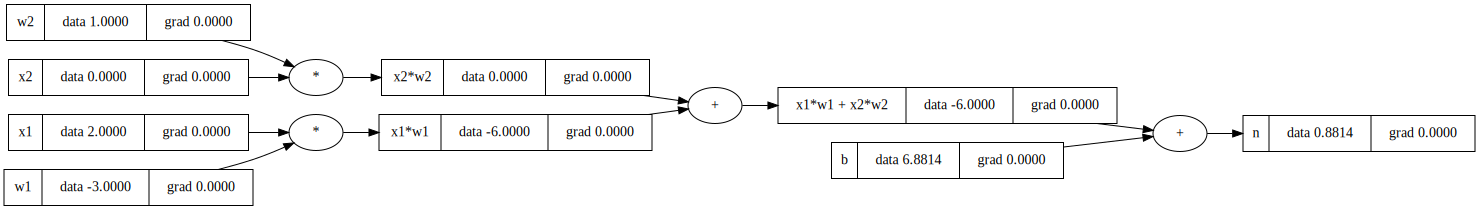

In [168]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
#6.8813735870195432
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
draw_dot(n)

In [169]:
o = n.tanh(); o.label = 'o'

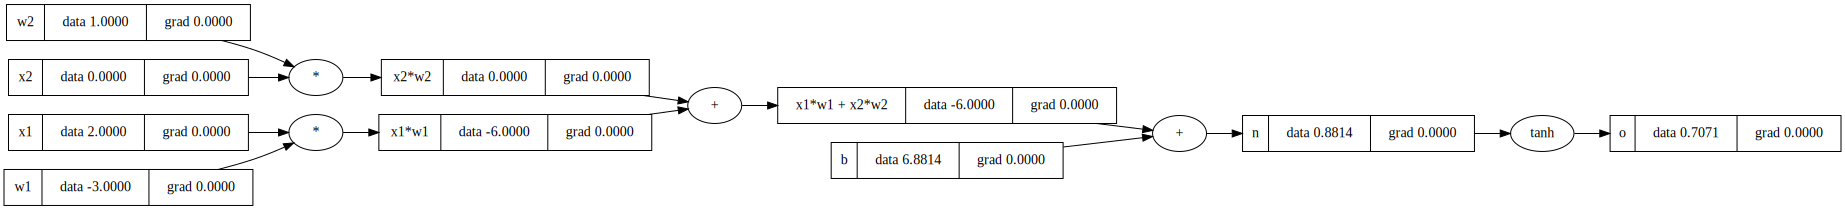

In [170]:
draw_dot(o)

Awesome n goes through tanh to produce the last output, our activation function is working great, now all we need to know is the derivative of tanh and we can use backpropagation.

In [171]:
o.grad = 1.0

Lets calculte the gradient of n

In [172]:
1 - o.data**2

0.4999999999999999

In [173]:
n.grad = 0.5

Now we can easily get the gradients for x1w1x2w1, b, x1w1, x2w2 since we used addition as an operation the local derivatives are just 1 so we just take the value 0.5

In [174]:
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

We can know calculate the gradients for x2, w2, x1, and w1, but unlike the last gradients we used multiplication as our operation, so our local derivative is just the other term used in the operation so lets calculate the gradients

In [175]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

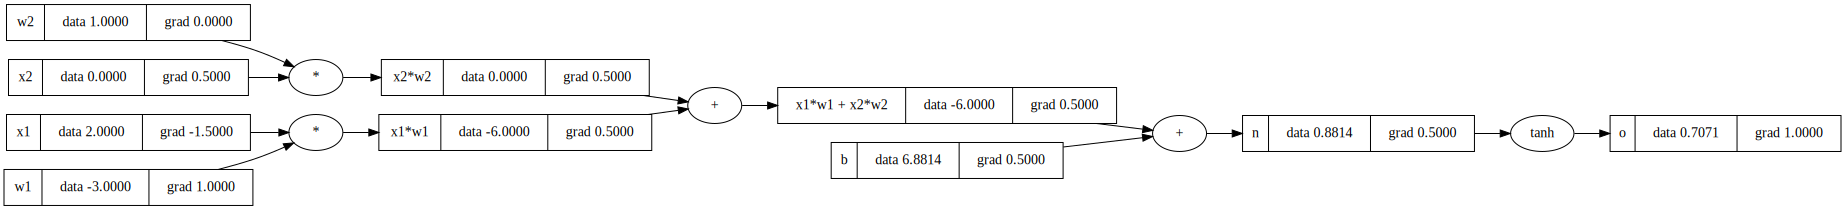

In [176]:
draw_dot(o)

Nice!, we have manually used backpropagation to calculate our gradients, now lets implement a backward function for each operation

<a id=4></a>
# [Backward Function](#content)

Lets add a backward methods to our Value object for each operation that we can call to calculate our gradients for us using backpropagation

In [177]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out 
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
                
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

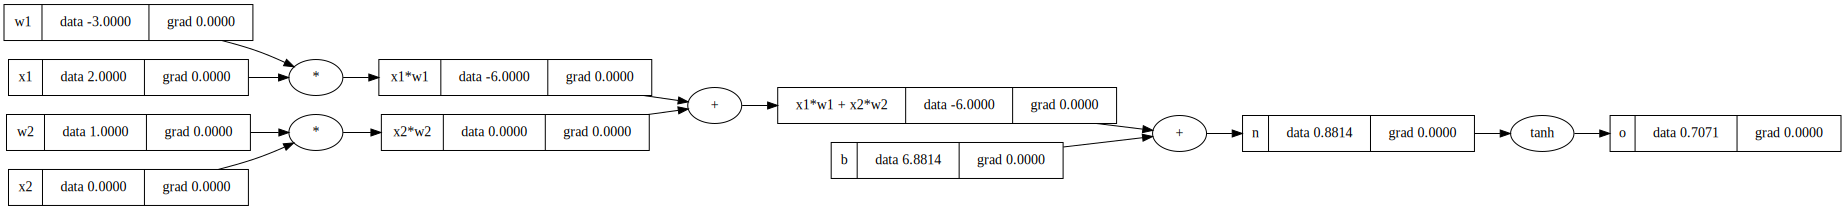

In [178]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
#6.8813735870195432
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

We initialize the gradient of o to 1.0, then call _backward to recursively calculate the gradients

In [179]:
o.grad = 1.0

In [180]:
o._backward()

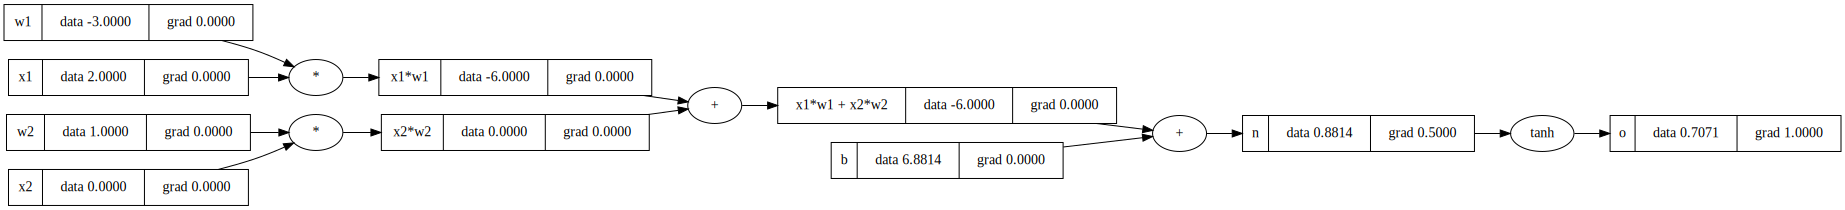

In [181]:
draw_dot(o)

In [182]:
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

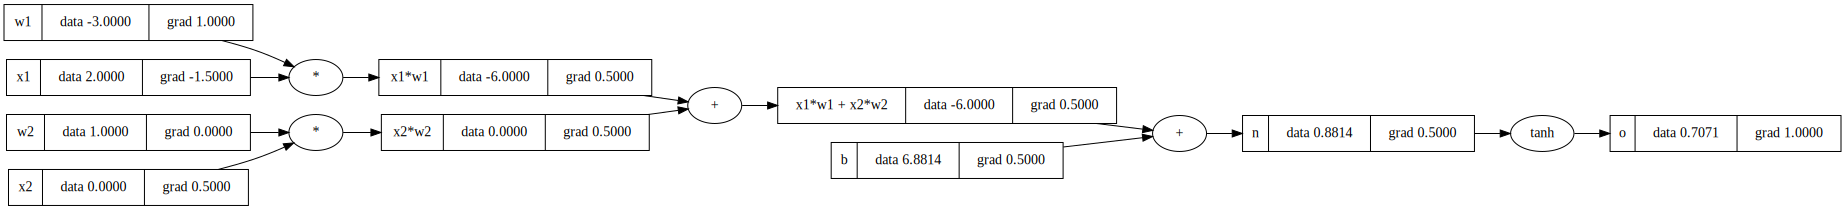

In [183]:
draw_dot(o)

Awesome, this works great, we never want to call backward() on a node before we have calculated the gradients for everthing after it since it depends on their gradients. We will use topological sort which lays the graph such that all the edges go only from left to right.

![img.png](https://miro.medium.com/max/1400/1*uMg_ojFXts2WZSjcZe4oRQ.png)

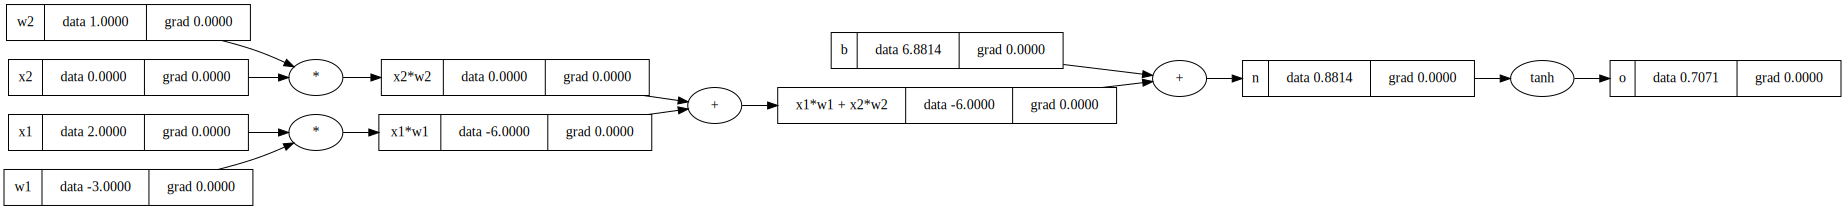

In [184]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
#6.8813735870195432
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [185]:
# topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Our Value objects are now ordered properly

In [186]:
o.grad = 1.0

In [187]:
for node in reversed(topo):
    node._backward()

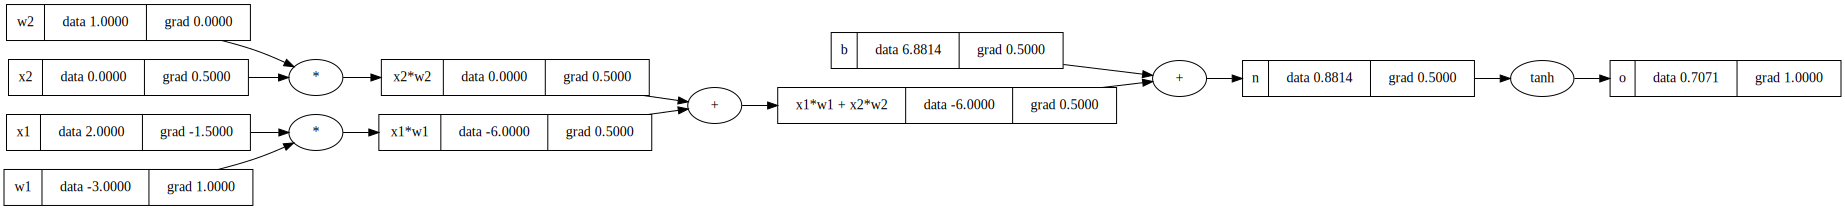

In [188]:
draw_dot(o)

<a id=5></a>
# [Lets implement this as a method in the Value object and add more operations](#content)

In [189]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out 
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
                
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
          self.grad += out.data * out.grad 
        out._backward = _backward

        return out
    # Now we can call backward on our Value object
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [190]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [191]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

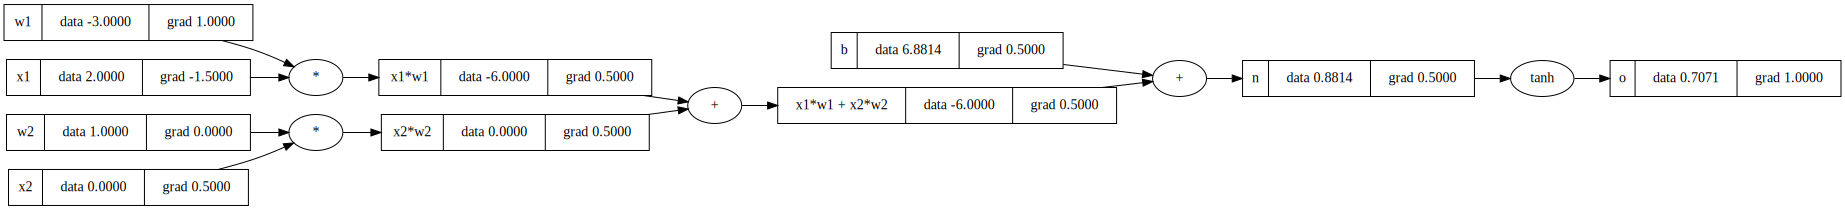

In [192]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

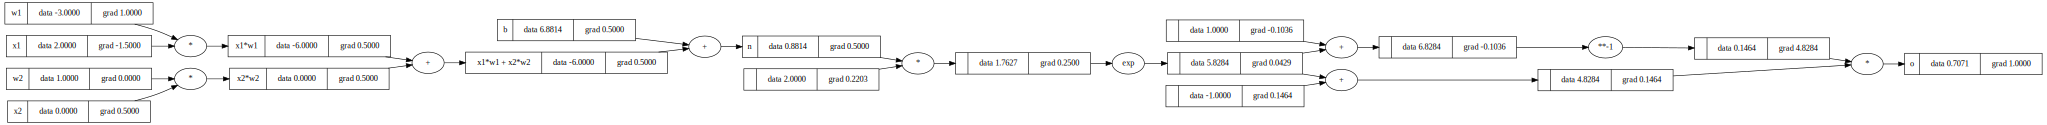

In [193]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

<a id=6></a>
# [Pytorch comparison](#content)

In [194]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [195]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [196]:
o.item()

0.7071066904050358

![img.png](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [222]:
import random


class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value(data=-0.7996908087576794)]